In [52]:
# Install necessary packages
!pip install tensorflow opencv-python gradio scikit-learn

In [53]:
# Import necessary libraries and modules
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import gradio as gr
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [54]:
# Confirm os lists the different folders in the data folder.
os.listdir('data')

['fake', 'real']

In [55]:
# Read in example image from data file.
img = cv2.imread(os.path.join('data','real','real_44.jpg'))

In [56]:
# Confirm image shape is 300 x 300 pixes, 3 channel color
img.shape

(300, 300, 3)

In [57]:
# Define the data directory where the dataset will be pulled from
data_dir = 'data'

In [58]:
# Define the data classes/labels
for image_class in os.listdir(data_dir):
    print(image_class)

fake
real


In [59]:
# Read in the data
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1289 files belonging to 2 classes.


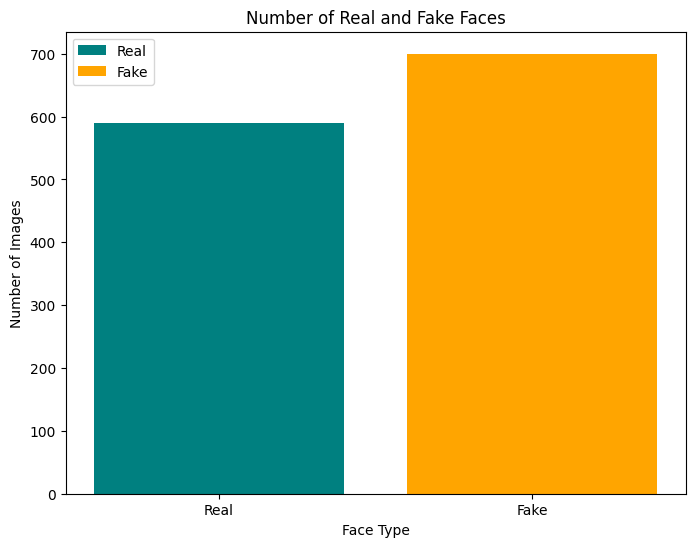

In [60]:
# Visualize the count of Real and Fake faces from the dataset

num_real = len(os.listdir(os.path.join(data_dir, 'real')))
num_fake = len(os.listdir(os.path.join(data_dir, 'fake')))

plt.figure(figsize=(8, 6))
bar_real = plt.bar(['Real'], [num_real], color='teal')
bar_fake = plt.bar(['Fake'], [num_fake], color='orange')
plt.title('Number of Real and Fake Faces')
plt.xlabel('Face Type')
plt.ylabel('Number of Images')
plt.legend([bar_real[0], bar_fake[0]], ['Real', 'Fake'])
plt.show()

In [61]:
# Iterator for getting a new batch of data.
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [62]:
# Confirm batch size of 32, confirm image shape of 256 x 256 pixels, 3 channel color
batch[0].shape

(32, 256, 256, 3)

In [63]:
# Get first batch.
# Class 0 is Fake, Class 1 is Real 
batch[1]

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0])

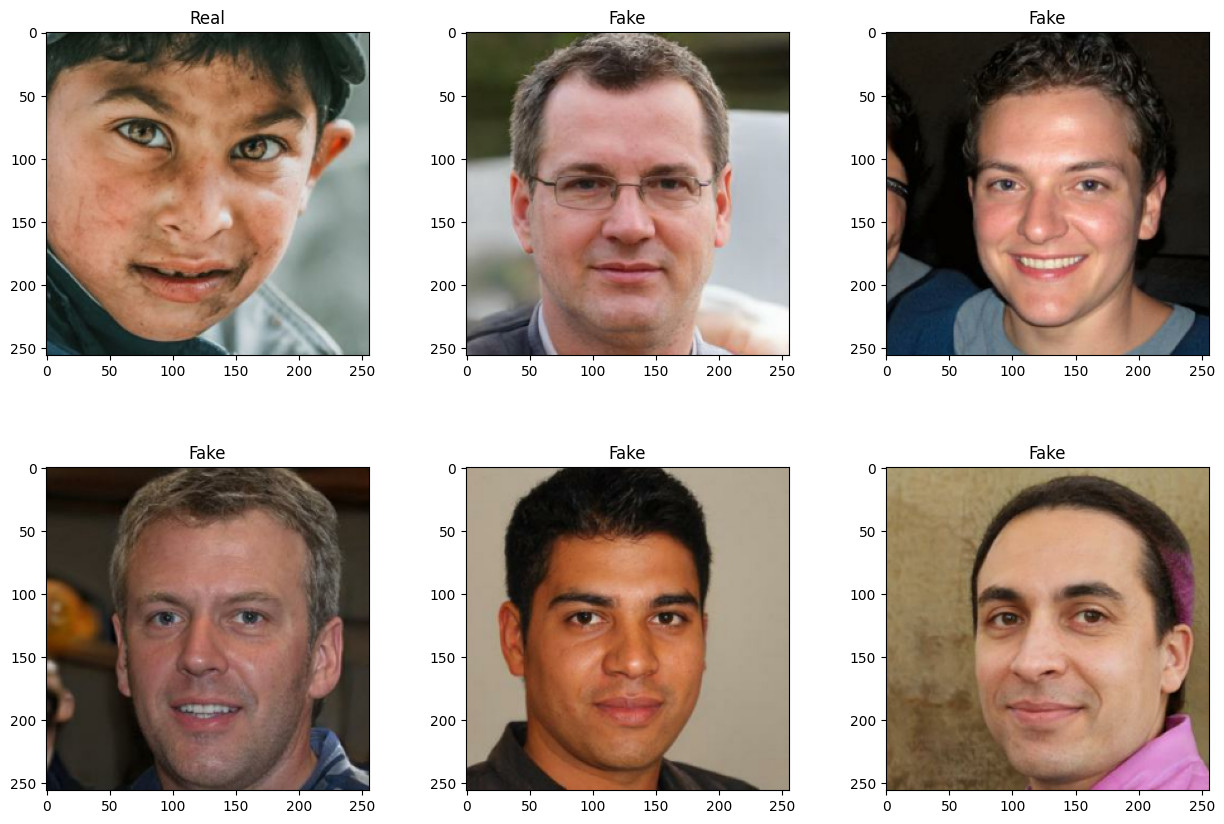

In [64]:
# Visualize batch data. give the data labels of real and fake. 

num_rows = 2
num_cols = 3


fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))


axes = axes.ravel()


data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()


for i, (img, label, ax) in enumerate(zip(batch[0], batch[1], axes)):

    ax.imshow(img.astype(int))
    
    ax.set_title(f"{'Fake' if label == 0 else 'Real'}")


plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

In [65]:
# Scale the data
data = data.map(lambda x,y: (x/255, y))

In [66]:
# Iterator for scaled data batches
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

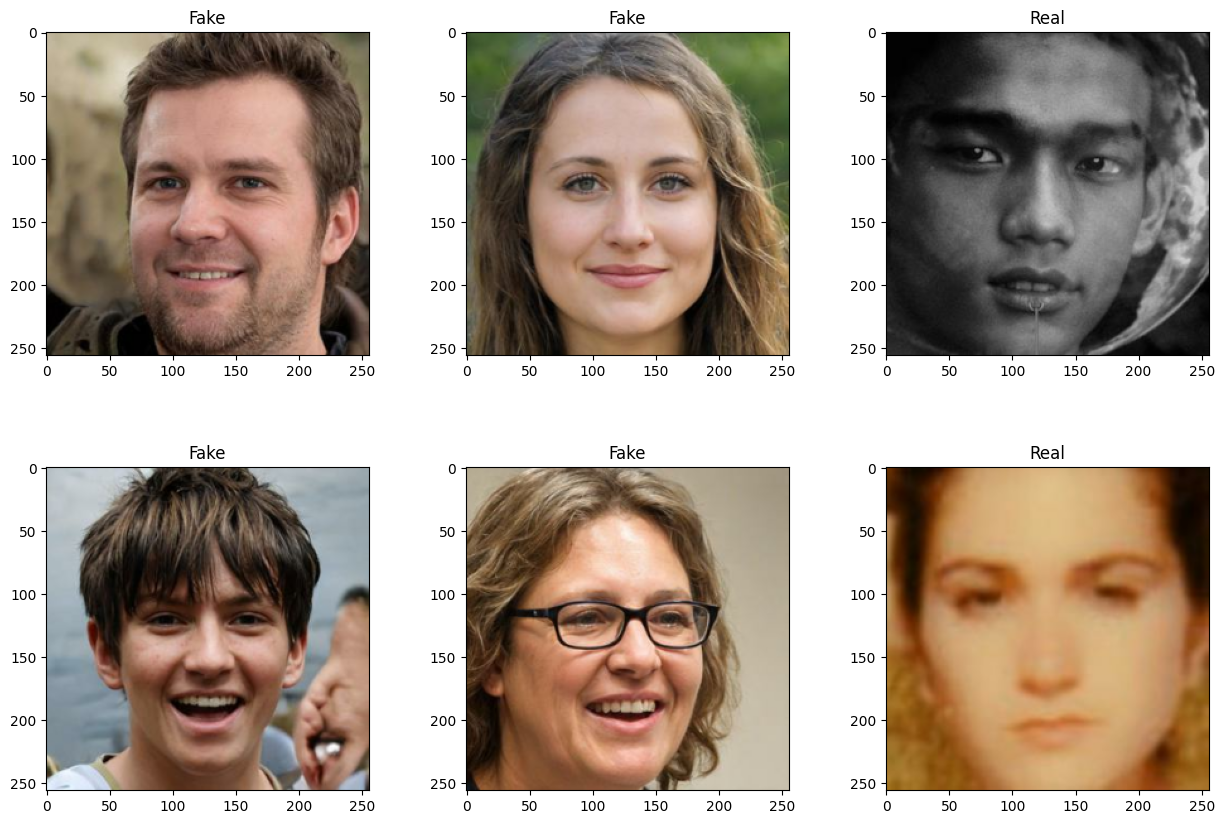

In [67]:
# Visualize scaled data to confirm the pixel values are still usable.
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

axes = axes.ravel()

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()


for i, (img, label, ax) in enumerate(zip(batch[0], batch[1], axes)):
    ax.imshow(img)

    
    ax.set_title(f"{'Fake' if label == 0 else 'Real'}")

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

In [68]:
# Confirm number of batches
len(data)

41

In [69]:
# Define the size of the training set, validation set, and test set so that the data batches can be split among them. 
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [70]:
# Confirm the split dataset is equal to the original number of batches.
train_size + val_size + test_size

41

In [71]:
# Split the data into the training set, validation set, and test set.
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

In [72]:
# imports for the AI model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [73]:
# Model variable.
model = Sequential()

In [74]:
# Model architecture, Convolutional Neural Network. 

model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [75]:
# Compile the model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [76]:
# Print a summary of the model architecture

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 254, 254, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,097,569 (8.00 MB)

 Trainable params: 2,097,569 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# Set directory for storing TensorBoard logs
logdir = 'logs'

In [78]:
# Create a TensorBoard callback to log training metrics and visualizations
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [79]:
# Train the AI model on the training data, validate with validation date. Train for 20 epochs.
hist = model.fit(train_data, epochs = 20, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5475 - loss: 0.6920 - val_accuracy: 0.6680 - val_loss: 0.6809
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - accuracy: 0.6679 - loss: 0.6410 - val_accuracy: 0.5508 - val_loss: 0.6834
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - accuracy: 0.6227 - loss: 0.6438 - val_accuracy: 0.5703 - val_loss: 0.6532
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.7922 - loss: 0.4706 - val_accuracy: 0.9453 - val_loss: 0.2319
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.9523 - loss: 0.1512 - val_accuracy: 0.9727 - val_loss: 0.1060
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.9881 - loss: 0.0359 - val_accuracy: 0.9805 - val_loss: 0.0895
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step - accuracy: 0.9773 - loss: 0.0854 - val_accuracy: 0.9922 - val_loss: 0.0683
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.9851 - loss: 0.0498 - val_accuracy: 0.

In [80]:
# Saves the model and the weights
# model.save('face_model.keras')
# model.save_weights('faces_model.weights.h5')

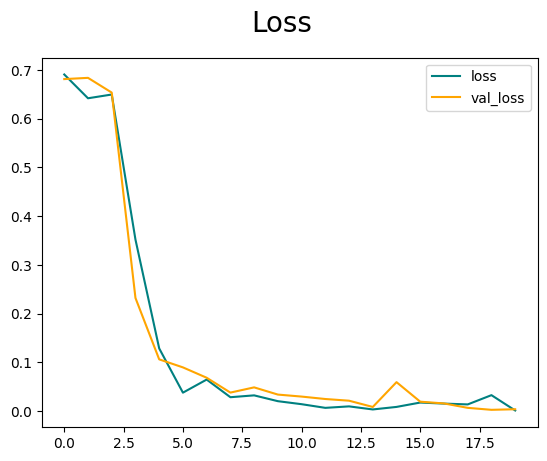

In [81]:
# Visualize Loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

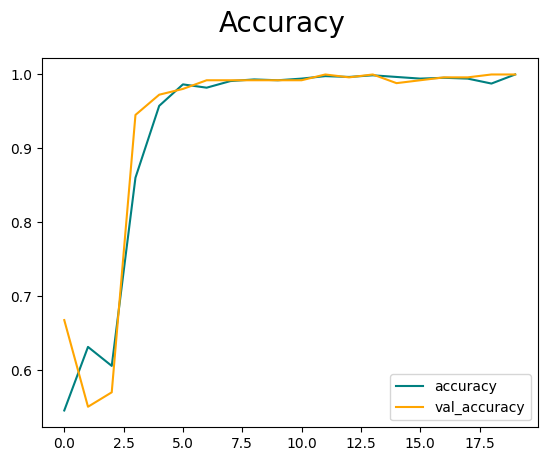

In [82]:
# Visualize Accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='lower right')
plt.show()

In [83]:
# Additional TensorFlow Metrics for reviewing data.
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [84]:
# Set variables for Precision, Recall, and Accuracy.
precision = Precision()
recall = Recall()
binAccuracy = BinaryAccuracy()

In [85]:
# Confirm number of images in test data.
len(test_data)

5

In [86]:
# Use the model to classify/predict the test data.
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    binAccuracy.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<Figure size 800x600 with 0 Axes>

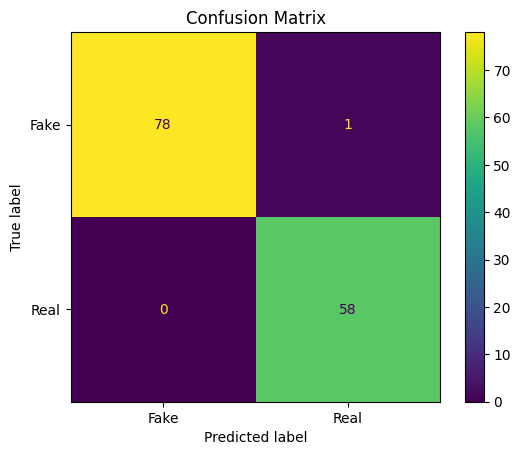

In [87]:
y_true = []
y_pred = []

for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    y_pred.extend(model.predict(X) > 0.5)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [88]:
# Print precision, recall, and accuracy of the model when classifying test data. 
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {binAccuracy.result().numpy()}')

Precision: 0.9848484992980957, Recall: 1.0, Accuracy: 0.9927007555961609


In [89]:
# Load a saved model for predictions.
model_predict = tf.keras.models.load_model('face_model.keras')

In [90]:
# Define prediction function

def predict(input_image):
    input_image = cv2.resize(input_image, (256, 256))
    input_image = np.expand_dims(input_image / 255, 0)
    prediction = model_predict.predict(input_image)
    
    if prediction > 0.5:
        result = "This face may be real"
    else:
        result = "This face may be fake"
    return result

In [91]:
# Create gradio user interface to upload images for the model to predict. 
input_image = gr.Image(label="Input Image")
output_label = gr.Label(label="Prediction")
interface = gr.Interface(fn=predict, inputs=input_image, outputs=output_label, title="Face Prediction Model")
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://b3cf6695beb7b8c266.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
